Using device: cpu


100%|██████████| 170M/170M [00:03<00:00, 53.2MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Loss: 2.2291
Epoch [2/10], Loss: 2.1343
Epoch [3/10], Loss: 2.2552
Epoch [4/10], Loss: 2.2432
Epoch [5/10], Loss: 1.9161
Epoch [6/10], Loss: 2.0277
Epoch [7/10], Loss: 1.9971
Epoch [8/10], Loss: 1.7466
Epoch [9/10], Loss: 2.1611
Epoch [10/10], Loss: 1.6323


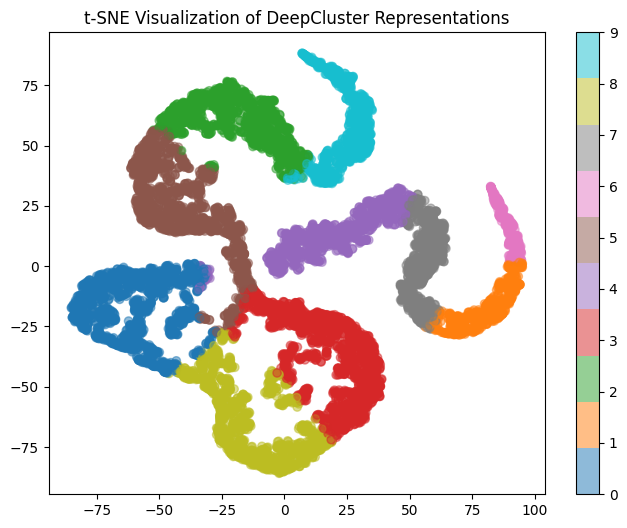

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader, Dataset, Subset

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define Data Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Select 10,000 random samples
subset_indices = torch.randperm(len(trainset))[:10000]
trainset = Subset(trainset, subset_indices)

trainloader = DataLoader(trainset, batch_size=512, shuffle=False, num_workers=0, pin_memory=True)

# Define the DeepCluster model
class DeepClusterModel(nn.Module):
    def __init__(self, num_clusters=10):
        super(DeepClusterModel, self).__init__()
        self.features = torchvision.models.resnet18(pretrained=False)
        self.features.fc = nn.Identity()  # Remove the classification layer
        self.cluster_head = nn.Linear(512, num_clusters)  # Cluster assignment layer

    def forward(self, x):
        x = self.features(x)
        x = nn.functional.normalize(x, dim=1)  # Normalize feature vectors
        x = self.cluster_head(x)
        return x

# Define the PseudoLabel dataset
class PseudoLabelDataset(Dataset):
        def __init__(self, dataset, pseudo_labels):
            self.dataset = dataset
            self.pseudo_labels = pseudo_labels

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            image, _ = self.dataset[idx]
            pseudo_label = self.pseudo_labels[idx]
            return image, pseudo_label

model = DeepClusterModel().to(device)

# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)

# Training parameters
epochs = 10
num_clusters = 10

# Training loop
for epoch in range(epochs):
    # Step 1: Extract features
    model.eval()
    features = []
    with torch.no_grad():
        for images, _ in trainloader:
            images = images.to(device)
            feats = model.features(images)
            features.append(feats.cpu().numpy())
    features = np.vstack(features)

    # Step 2: Clustering using K-Means
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
    cluster_assignments = kmeans.fit_predict(features)

    # Step 3: Create pseudo-labels dataset
    pseudo_dataset = PseudoLabelDataset(trainset, cluster_assignments)
    pseudo_loader = DataLoader(pseudo_dataset, batch_size=512, shuffle=True, num_workers=0, pin_memory=True)

    # Step 4: Train with pseudo-labels
    model.train()
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    for images, pseudo_labels in pseudo_loader:
        images, pseudo_labels = images.to(device), pseudo_labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, pseudo_labels.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(pseudo_loader):.4f}")

# Feature extraction for visualization
model.eval()
features = []
with torch.no_grad():
    for images, _ in trainloader:
        images = images.to(device)
        feats = model.features(images)
        features.append(feats.cpu().numpy())
features = np.vstack(features)
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
cluster_assignments = kmeans.fit_predict(features)

# t-SNE Visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_features = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_assignments, cmap='tab10', alpha=0.5)
plt.colorbar(scatter)
plt.title("t-SNE Visualization of DeepCluster Representations")
plt.show()